# Verify the performance of detecting structures with low quality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.dpi"] = 150
sns.set(style='darkgrid')
from IPython.display import display
import warnings
warnings.simplefilter('ignore', UserWarning)
from pathlib import Path
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.size"] = 15
plt.rcParams['figure.figsize'] = (6, 4)

In [2]:
data_dir = Path('../../../../../data/')
dataset_dir = data_dir / 'out' / 'dataset'
subset_name = 'target_subset_' + Path('.').resolve().parent.name
score_dir = dataset_dir / 'score' / 'subsets' / subset_name
assert score_dir.exists()
fig_dir = score_dir / 'fig' / 'MQA'
fig_dir.mkdir(parents=True, exist_ok=True)
target_list = data_dir / 'interim' / f'{subset_name}.csv'
assert target_list.exists()

In [3]:
label_path = score_dir / 'label.csv'
label_df = pd.read_csv(label_path, index_col=0)
target_df = pd.read_csv(target_list, index_col=0)
label_df = pd.merge(label_df, target_df, left_on='Target', right_on='id', how='left')
for i, csv in enumerate(sorted(score_dir.glob('*.csv'))):
    if csv.stem == 'label':
        continue
    if i == 0:
        mqa_df = pd.read_csv(csv, index_col=0)
    else:
        mqa_df = pd.merge(mqa_df, pd.read_csv(csv, index_col=0), on=['Model', 'Target'], how='outer')
mqa_df['DOPE'] = - mqa_df['DOPE']
mqa_df['SOAP'] = - mqa_df['SOAP']
df = pd.merge(label_df, mqa_df, on=['Target', 'Model'], how='left')
df

,Model,TMscore,GDT_TS,GDT_HA,Global_LDDT,Mean_LDDT,pLDDT,pTMscore,Tolerance,ModelName,...,SOAP,DeepAccNet,DeepAccNet-Bert,P3CMQA,ProQ2D,ProQRosCenD,ProQRosFAD,ProQ3D,SBROD,VoroCNN
0,model_1_ptm_seed_0_rec_10_ens_1,0.981,0.965,0.857,0.899,0.894,0.936,0.892,0.084,model_1_ptm,...,116971.344,0.977,0.981,0.941,0.660,0.690,0.922,0.795,1.561,0.679
1,model_1_ptm_seed_0_rec_10_ens_8,0.981,0.966,0.859,0.900,0.895,0.937,0.893,0.054,model_1_ptm,...,117449.914,0.978,0.981,0.941,0.664,0.691,0.924,0.798,1.563,0.679
2,model_1_ptm_seed_0_rec_1_ens_1,0.980,0.965,0.852,0.901,0.896,0.928,0.887,26.445,model_1_ptm,...,118798.586,0.975,0.971,0.939,0.621,0.658,0.906,0.763,1.560,0.680
3,model_1_ptm_seed_0_rec_1_ens_8,0.980,0.964,0.856,0.899,0.895,0.928,0.887,26.413,model_1_ptm,...,117463.500,0.973,0.971,0.939,0.625,0.677,0.910,0.770,1.561,0.679
4,model_1_ptm_seed_0_rec_2_ens_1,0.980,0.961,0.852,0.900,0.895,0.933,0.890,0.391,model_1_ptm,...,118283.023,0.976,0.971,0.941,0.667,0.697,0.922,0.804,1.562,0.677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36995,model_5_seed_1_rec_5_ens_1,0.966,0.900,0.735,0.835,0.823,0.784,NaN,0.917,model_5,...,236079.938,0.779,0.901,0.771,0.610,0.566,0.776,0.703,1.912,0.584
36996,model_5_seed_1_rec_6_ens_1,0.965,0.902,0.737,0.835,0.824,0.784,NaN,1.534,model_5,...,236481.766,0.774,0.893,0.773,0.631,0.582,0.787,0.715,1.916,0.583
36997,model_5_seed_1_rec_7_ens_1,0.965,0.901,0.735,0.835,0.824,0.785,NaN,1.668,model_5,...,237071.953,0.778,0.889,0.771,0.639,0.586,0.787,0.717,1.915,0.585
36998,model_5_seed_1_rec_8_ens_1,0.965,0.897,0.732,0.835,0.823,0.785,NaN,1.460,model_5,...,236660.281,0.785,0.884,0.772,0.629,0.578,0.784,0.709,1.921,0.586


In [4]:
# Against gdtts
mqa_methods = ['DOPE', 'SOAP', 'ProQ3D', 'SBROD', 'VoroCNN', 'P3CMQA', 'DeepAccNet', 'DeepAccNet-Bert']
methods = mqa_methods + ['pLDDT', 'pTMscore']

## Case 1: Negative examples are structures with the label value is less than the threshold value

In [5]:
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'Mean_LDDT']
thresholds = [0.5, 0.6, 0.7, 0.8]
counts = []
for label in labels:
    for threshold in thresholds:
        l = f'{label}_{threshold}'
        df[l] = df[label] > threshold
        counts.append(df[l].value_counts())
pd.concat(counts, axis=1).T.fillna(0).astype(int)

,True,False
GDT_TS_0.5,36968,32
GDT_TS_0.6,36650,350
GDT_TS_0.7,34914,2086
GDT_TS_0.8,32482,4518
GDT_HA_0.5,36216,784
GDT_HA_0.6,34545,2455
GDT_HA_0.7,30855,6145
GDT_HA_0.8,23628,13372
TMscore_0.5,37000,0
TMscore_0.6,36894,106


In [6]:
label = 'GDT_TS'
threshold = 0.7
l = f'{label}_{threshold}'
df[l]

0        True
1        True
2        True
3        True
4        True
         ... 
36995    True
36996    True
36997    True
36998    True
36999    True
Name: GDT_TS_0.7, Length: 37000, dtype: bool

In [7]:
from sklearn.metrics import roc_curve, auc

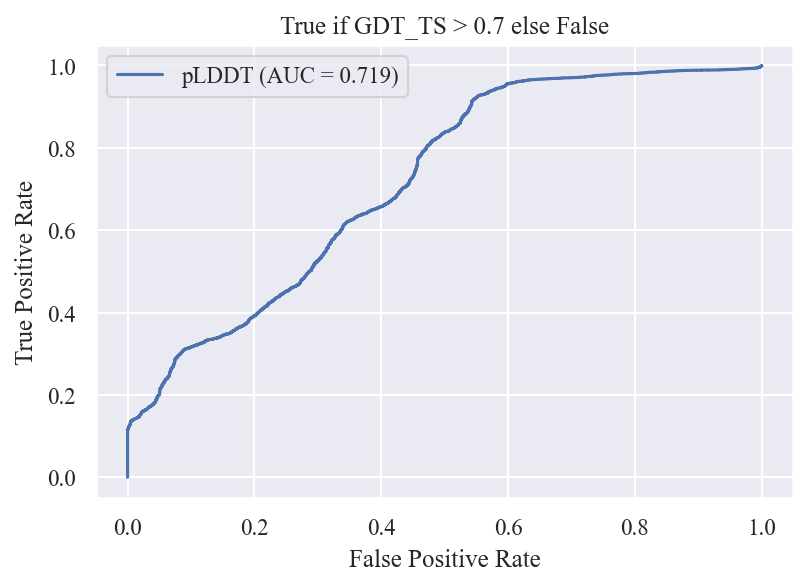

In [8]:
label = 'GDT_TS'
threshold = 0.7
l = f'{label}_{threshold}'
x = df[l]
score = 'pLDDT'
y = df[score]
fpr, tpr, thresholds = roc_curve(x, y)
a= auc(fpr, tpr)
plt.title(f'True if {label} > {threshold} else False')
plt.plot(fpr, tpr, label=f'{score} (AUC = {a:.3f})')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37000 entries, 0 to 36999
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Model                                37000 non-null  object 
 1   TMscore                              37000 non-null  float64
 2   GDT_TS                               37000 non-null  float64
 3   GDT_HA                               37000 non-null  float64
 4   Global_LDDT                          36000 non-null  float64
 5   Mean_LDDT                            36000 non-null  float64
 6   pLDDT                                37000 non-null  float64
 7   pTMscore                             18500 non-null  float64
 8   Tolerance                            37000 non-null  float64
 9   ModelName                            37000 non-null  object 
 10  Seed                                 37000 non-null  int64  
 11  Recycle                     

In [10]:
df[df['ProQ3D'].isna()]['Target'].value_counts()

Series([], Name: Target, dtype: int64)

In [11]:
methods

['DOPE',
 'SOAP',
 'ProQ3D',
 'SBROD',
 'VoroCNN',
 'P3CMQA',
 'DeepAccNet',
 'DeepAccNet-Bert',
 'pLDDT',
 'pTMscore']

In [12]:
df['pTMscore'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
36995     True
36996     True
36997     True
36998     True
36999     True
Name: pTMscore, Length: 37000, dtype: bool

In [13]:
y.isna().any()

False

pTMscore


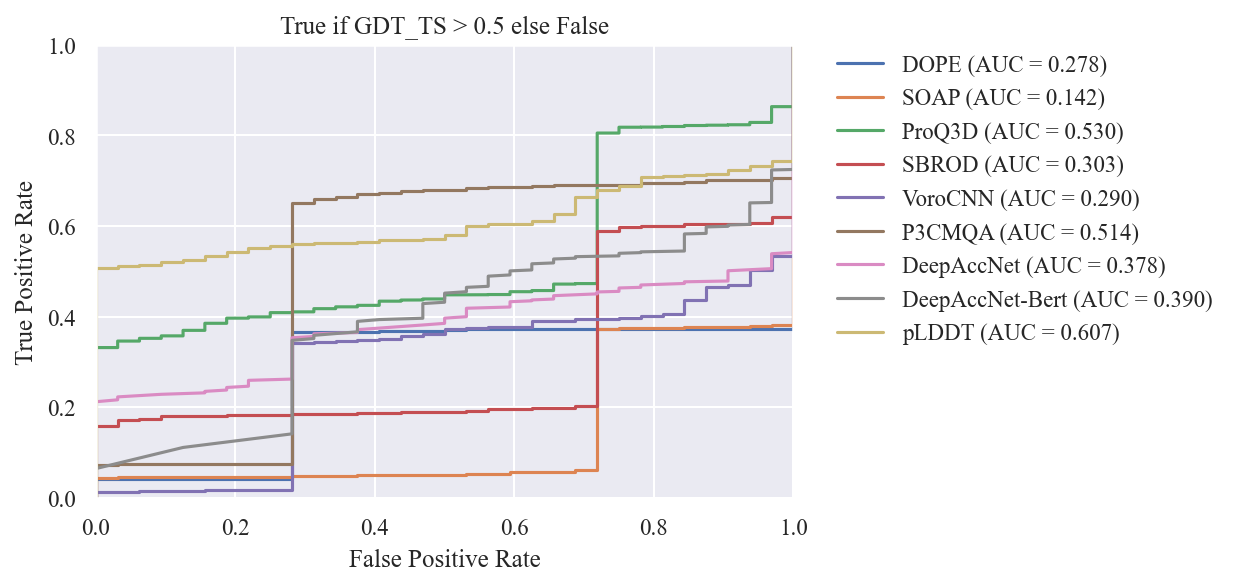

<Figure size 750x600 with 0 Axes>

pTMscore


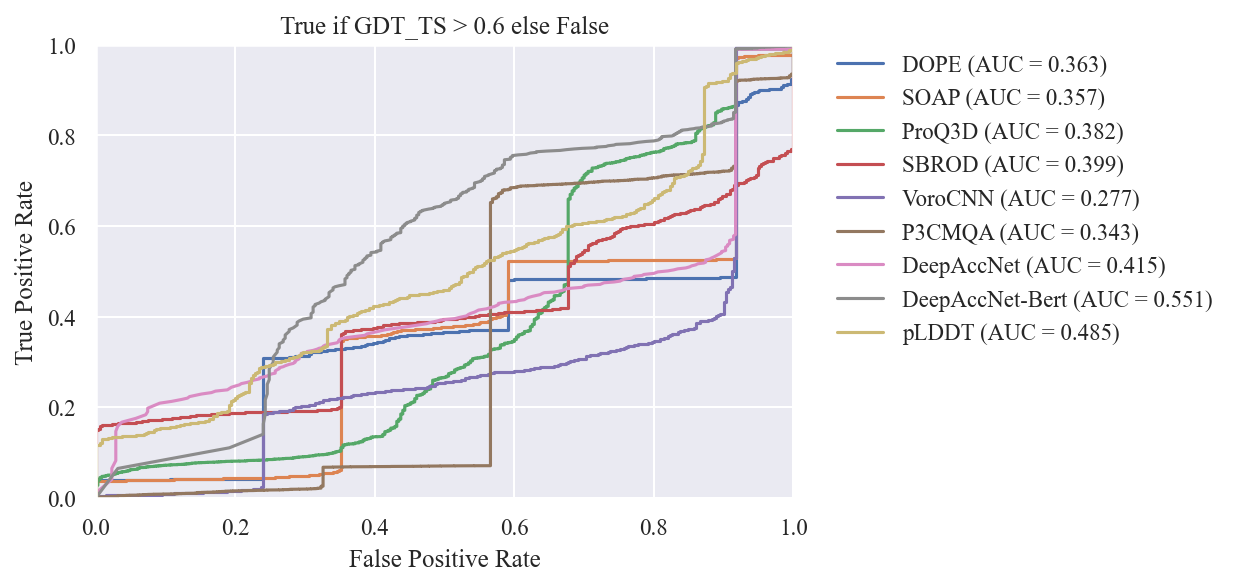

<Figure size 750x600 with 0 Axes>

pTMscore


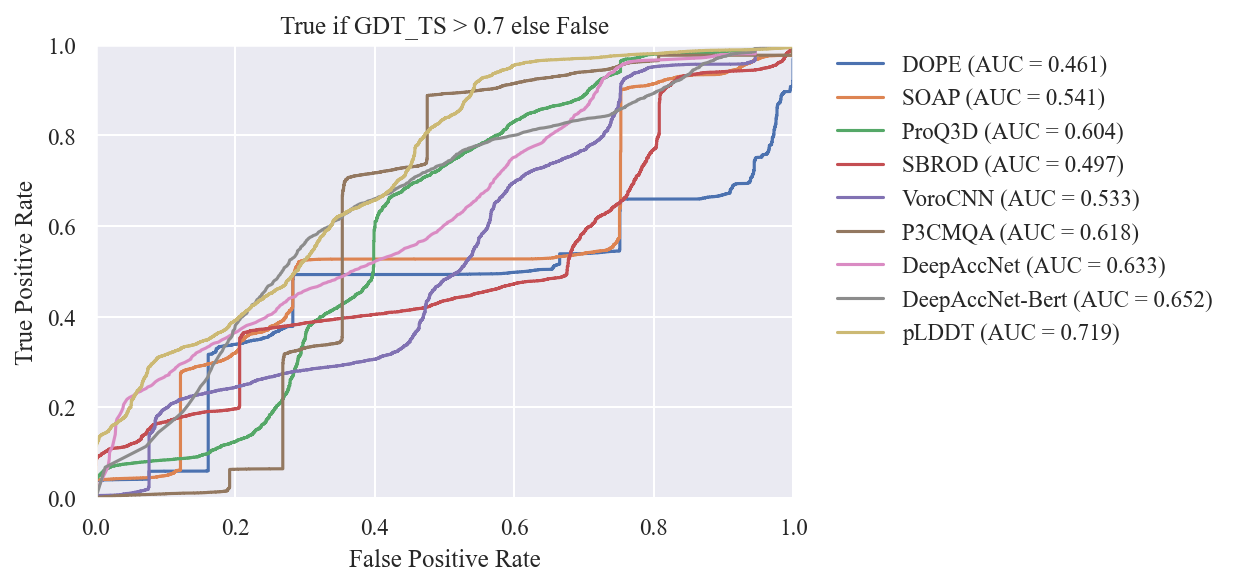

<Figure size 750x600 with 0 Axes>

pTMscore


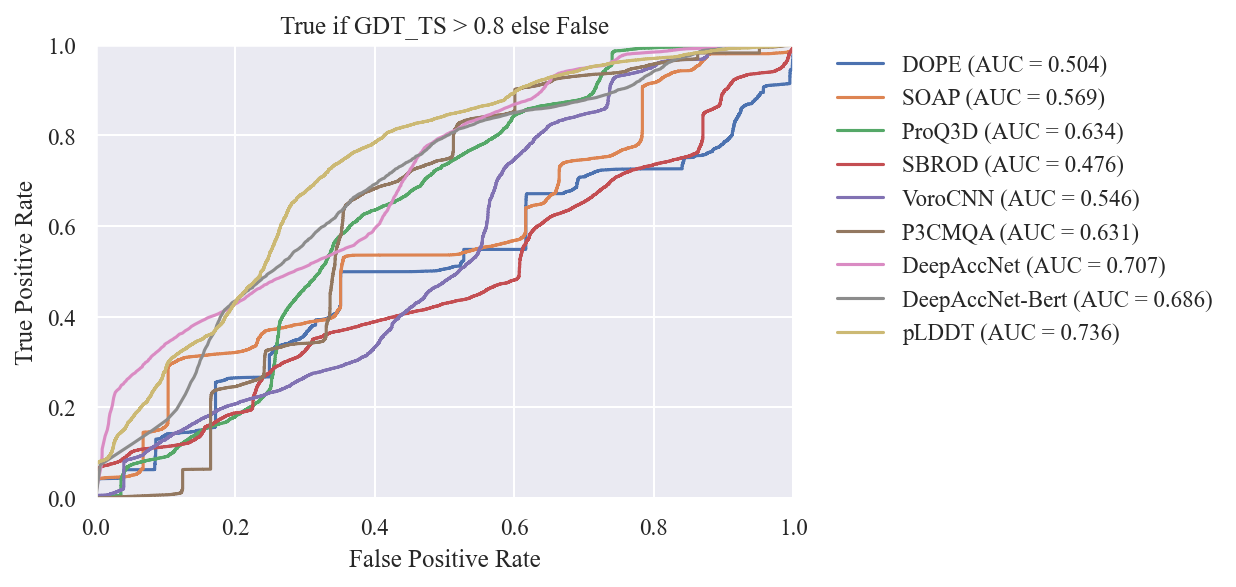

<Figure size 750x600 with 0 Axes>

pTMscore


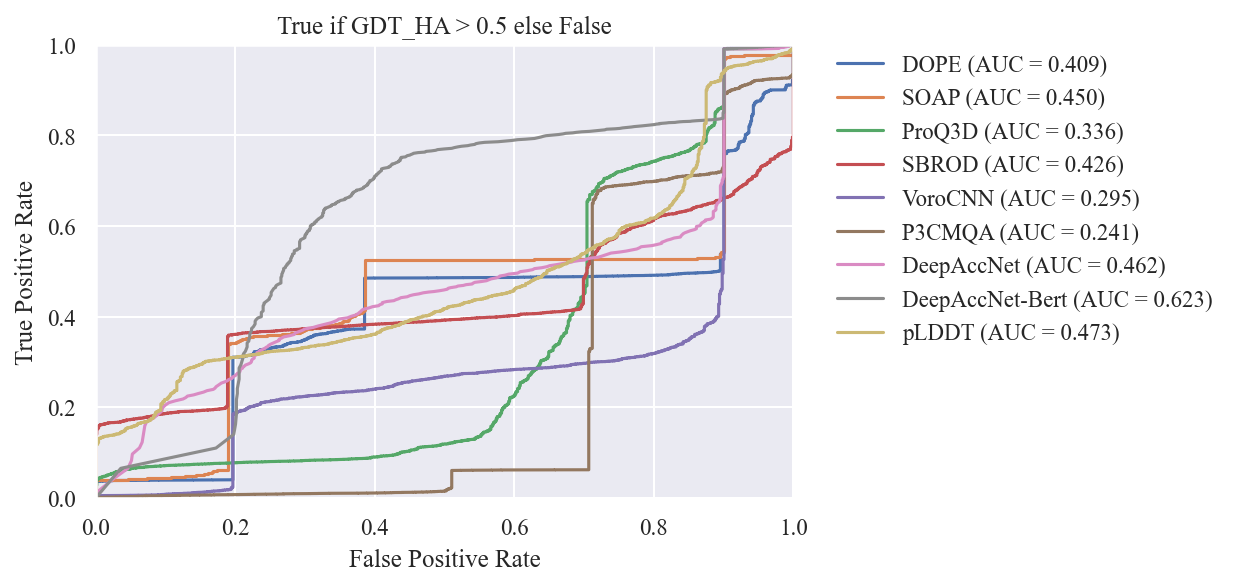

<Figure size 750x600 with 0 Axes>

pTMscore


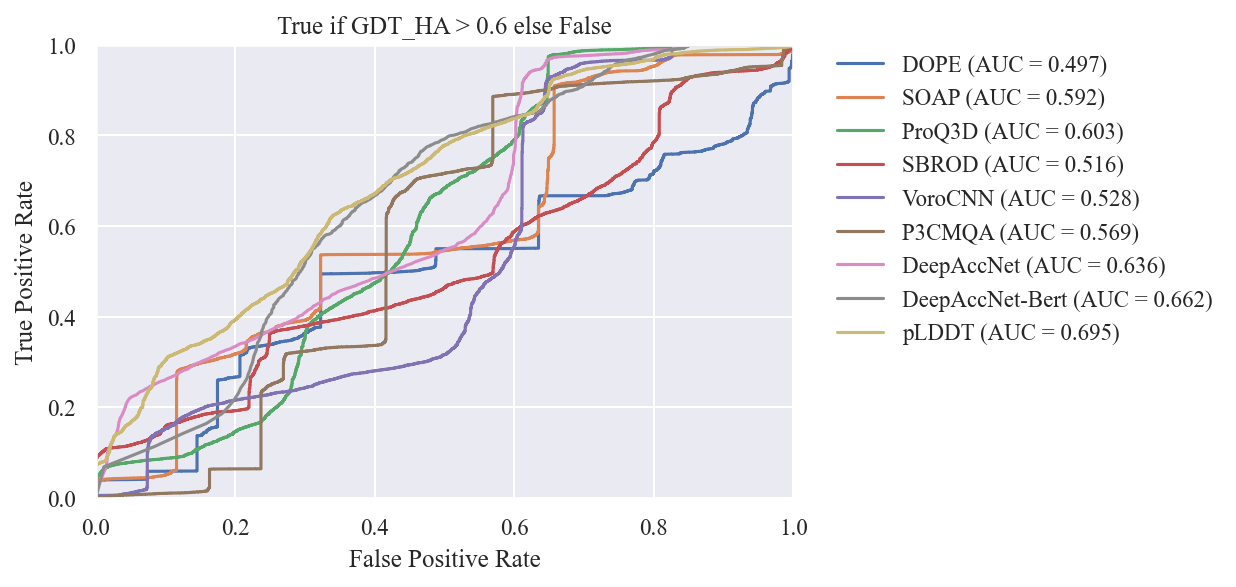

<Figure size 750x600 with 0 Axes>

pTMscore


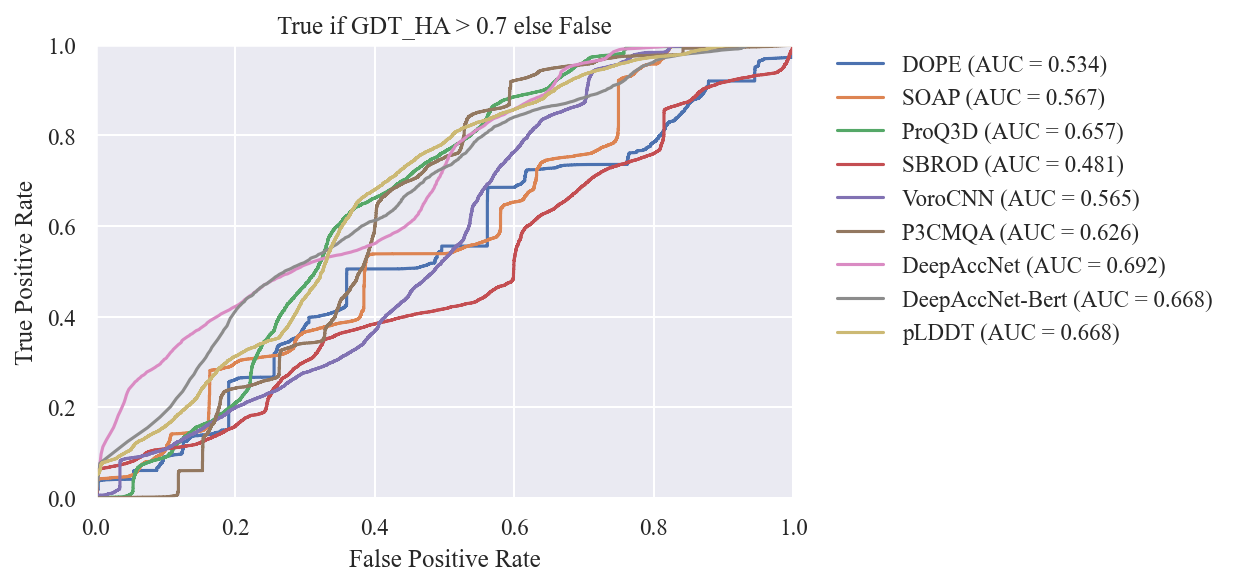

<Figure size 750x600 with 0 Axes>

pTMscore


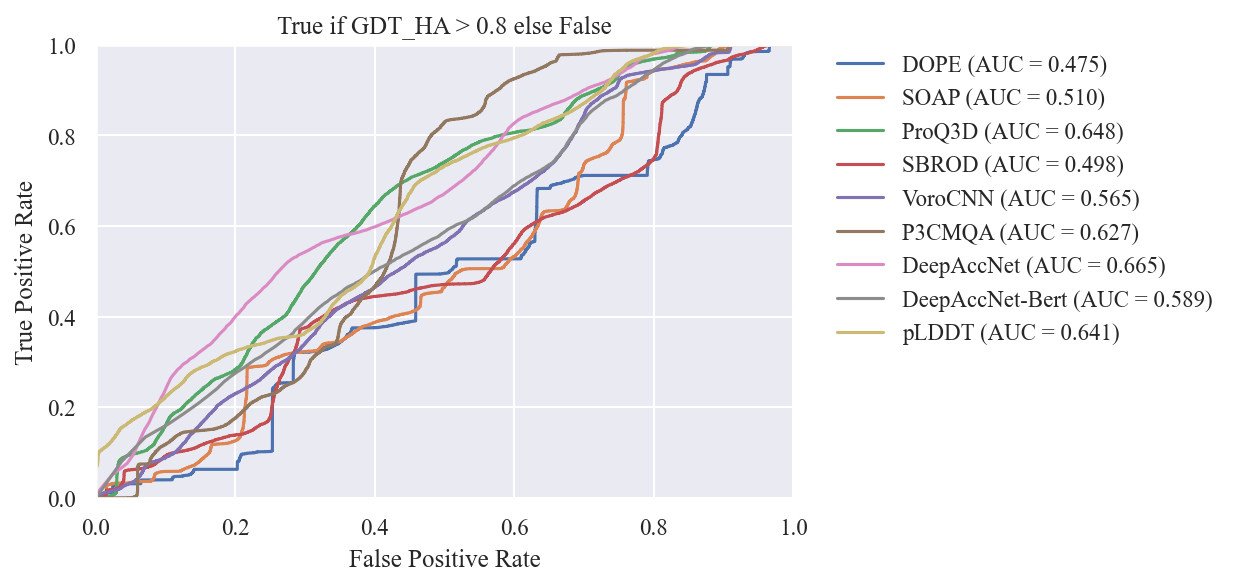

<Figure size 750x600 with 0 Axes>

pTMscore


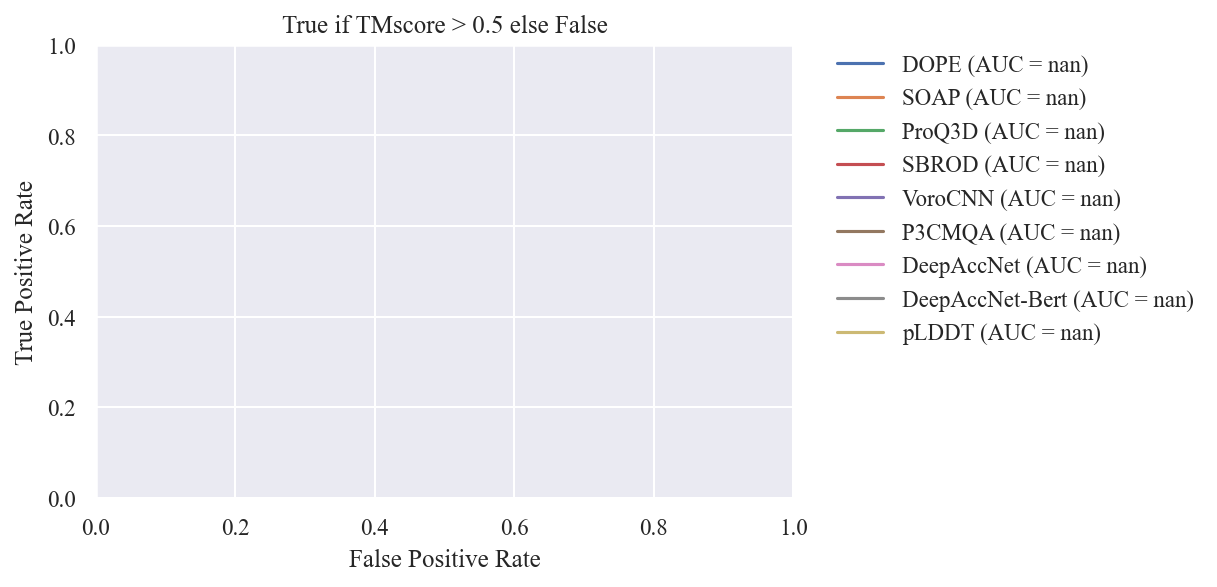

<Figure size 750x600 with 0 Axes>

pTMscore


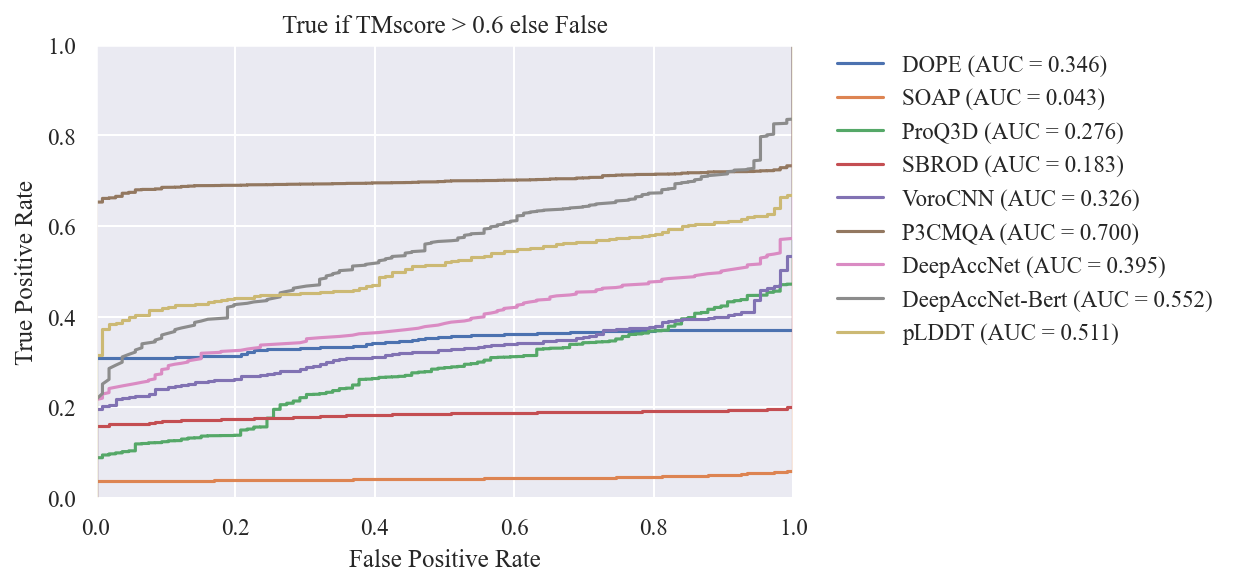

<Figure size 750x600 with 0 Axes>

pTMscore


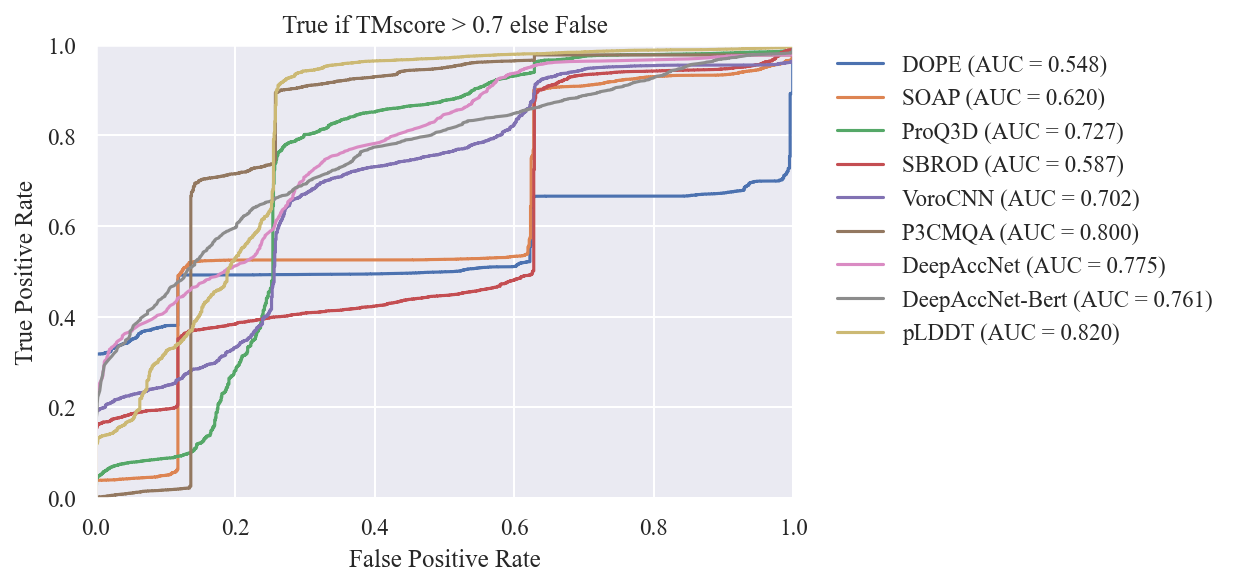

<Figure size 750x600 with 0 Axes>

pTMscore


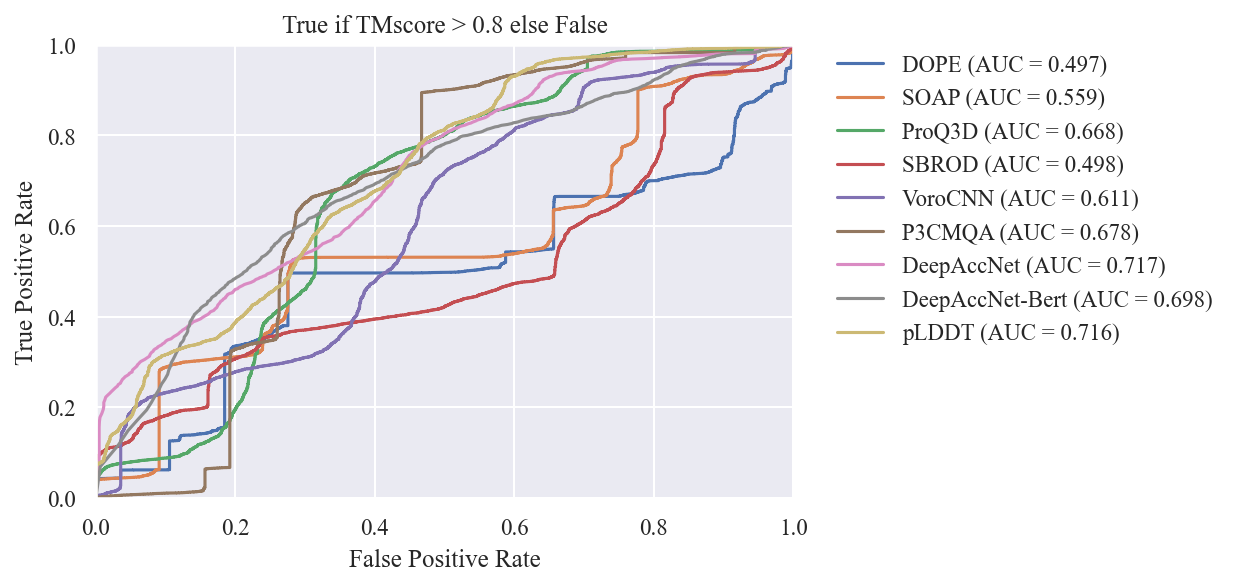

<Figure size 750x600 with 0 Axes>

pTMscore


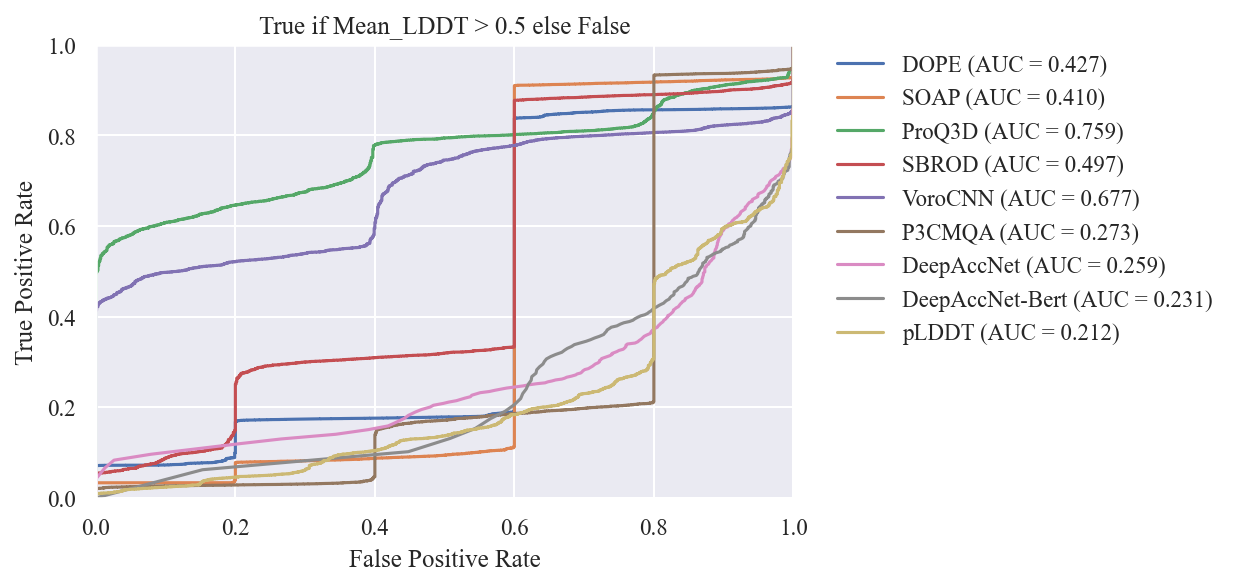

<Figure size 750x600 with 0 Axes>

pTMscore


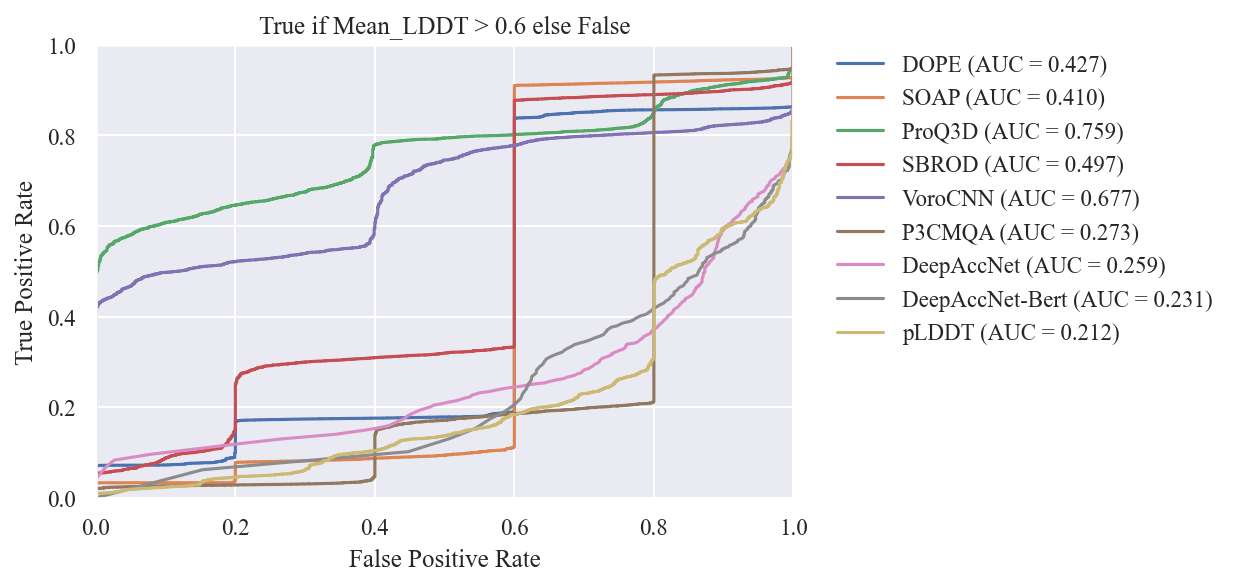

<Figure size 750x600 with 0 Axes>

pTMscore


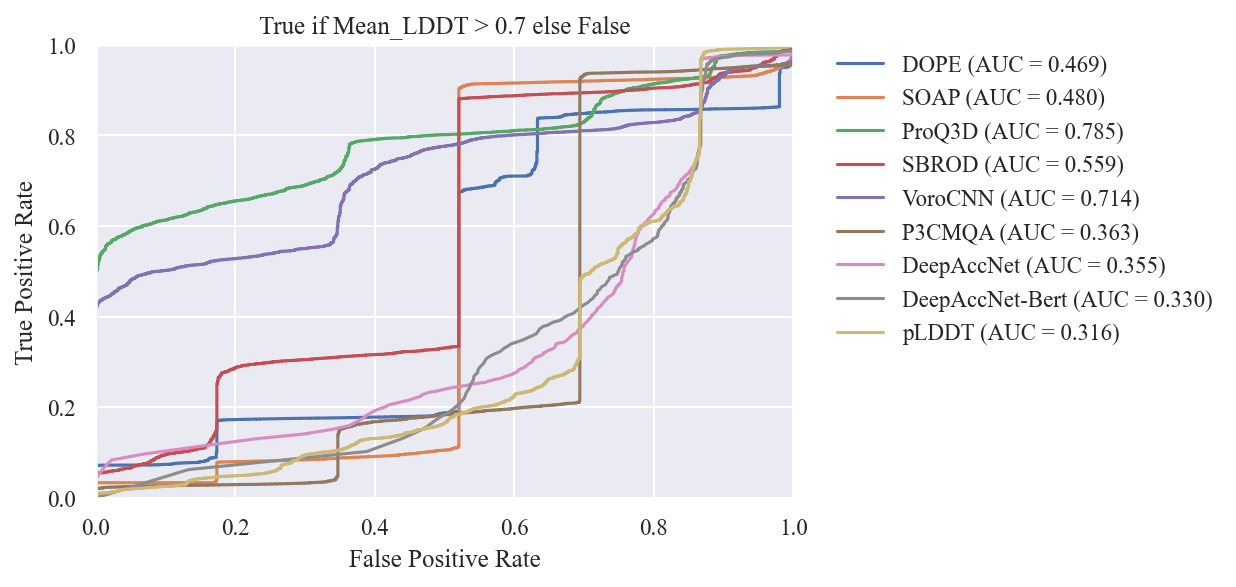

<Figure size 750x600 with 0 Axes>

pTMscore


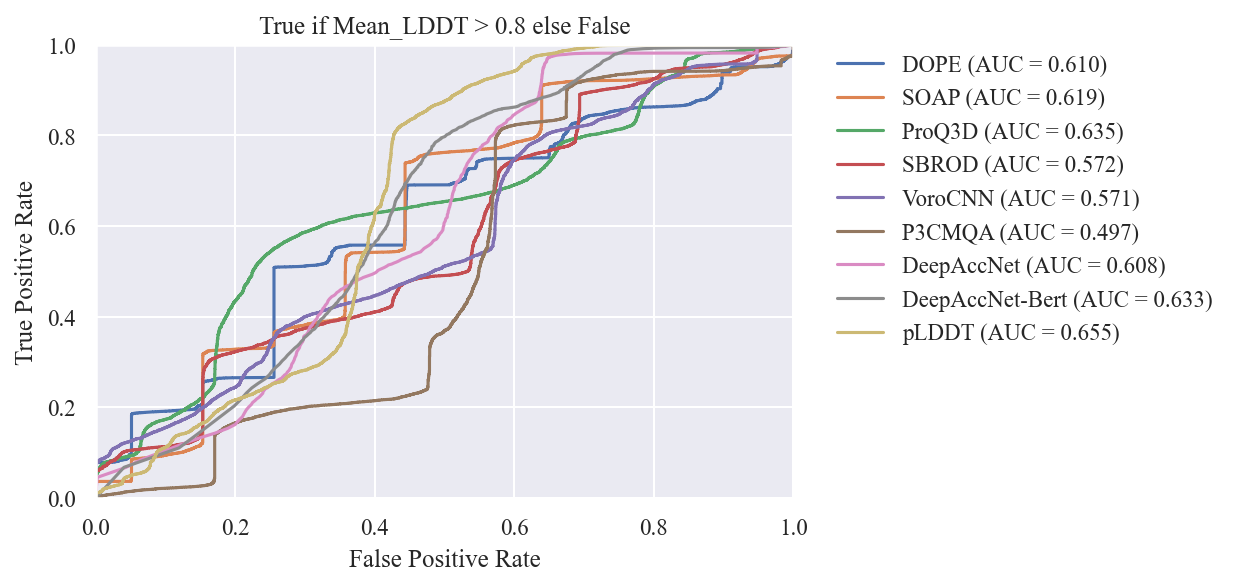

<Figure size 750x600 with 0 Axes>

In [14]:
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'Mean_LDDT']
thresholds = [0.5, 0.6, 0.7, 0.8]
counts = []
for label in labels:
    for threshold in thresholds:
        l = f'{label}_{threshold}'
        x = df[l]
        # score = 'pLDDT'
        for score in methods:
            y = df[score]
            if y.isna().any():
                print(score)
                continue
            fpr, tpr, thres = roc_curve(x, y)
            a= auc(fpr, tpr)
            plt.title(f'True if {label} > {threshold} else False')
            plt.plot(fpr, tpr, label=f'{score} (AUC = {a:.3f})')
            plt.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, facecolor='white', edgecolor='white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.figure(figsize=(5, 4))
        plt.tight_layout()
        plt.show()

## Case 2: Negative examples are structures whose label value is lower than the maximum label value by more than threshold

In [15]:
def split_tf_in_target(group: pd.DataFrame, label: str, threshold: float):
    """False for structures that are a threshold value away from the maximum label value in the target

    Args:
        group (pd.DataFrame): DataFrame of a target.
        label (str, optional): label name. Defaults to 'GDT_TS'.
        threshold (float, optional): Threshold. Defaults to 0.05.
    """
    max_value = group[label].max()
    l = f'{label}-{threshold}'
    group[l] = df[label] + threshold > max_value
    if group[l].all():
        return None
    return group
label = 'GDT_TS'
threshold = 0.05
rel_df = df.groupby('Target').apply(lambda x: split_tf_in_target(x, label, threshold)).reset_index(drop=True)
l = f'{label}-{threshold}'
rel_df[l].value_counts()

True     6860
False    4740
Name: GDT_TS-0.05, dtype: int64

In [16]:
results = []
for method in methods:
    aucs = []
    for name, group in rel_df.groupby('Target'):
        if group[method].isna().any():
                continue
        tpr, fpr, thres = roc_curve(group[l], group[method])
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)
    results.append({'Method': method, 'AUC': np.mean(aucs)})
pd.DataFrame(results)

/Users/TAKEI/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/TAKEI/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Method,AUC
0,DOPE,0.412
1,SOAP,0.369
2,ProQ3D,0.476
3,SBROD,0.539
4,VoroCNN,0.418
5,P3CMQA,0.455
6,DeepAccNet,0.319
7,DeepAccNet-Bert,0.365
8,pLDDT,0.320
9,pTMscore,NaN


In [17]:
labels = ['GDT_TS', 'GDT_HA', 'TMscore']
thresholds = [0.05, 0.1, 0.15, 0.2]
for label in labels:
    for threshold in thresholds:
        rel_df = df.groupby('Target').apply(lambda x: split_tf_in_target(x, label, threshold)).reset_index(drop=True)
        l = f'{label}-{threshold}'
        print(label, threshold)
        print(rel_df[l].value_counts())
        print(rel_df['Target'].unique().size)
        results = []
        for method in methods:
            aucs = []
            for name, group in rel_df.groupby('Target'):
                if group[method].isna().any():
                        continue
                tpr, fpr, thres = roc_curve(group[l], group[method])
                auc_score = auc(fpr, tpr)
                aucs.append(auc_score)
            if len(aucs) == 0:
                continue
            results.append({'Method': method, 'AUC': np.mean(aucs)})
        display(pd.DataFrame(results))

GDT_TS 0.05
True     6860
False    4740
Name: GDT_TS-0.05, dtype: int64
34


,Method,AUC
0,DOPE,0.412
1,SOAP,0.369
2,ProQ3D,0.476
3,SBROD,0.539
4,VoroCNN,0.418
5,P3CMQA,0.455
6,DeepAccNet,0.319
7,DeepAccNet-Bert,0.365
8,pLDDT,0.320


GDT_TS 0.1
True     4267
False    1533
Name: GDT_TS-0.1, dtype: int64
17


,Method,AUC
0,DOPE,0.361
1,SOAP,0.349
2,ProQ3D,0.451
3,SBROD,0.528
4,VoroCNN,0.315
5,P3CMQA,0.376
6,DeepAccNet,0.274
7,DeepAccNet-Bert,0.445
8,pLDDT,0.277


GDT_TS 0.15
True     2159
False     641
Name: GDT_TS-0.15, dtype: int64
9


,Method,AUC
0,DOPE,0.198
1,SOAP,0.200
2,ProQ3D,0.398
3,SBROD,0.501
4,VoroCNN,0.292
5,P3CMQA,0.256
6,DeepAccNet,0.277
7,DeepAccNet-Bert,0.351
8,pLDDT,0.194


GDT_TS 0.2
True     1323
False     477
Name: GDT_TS-0.2, dtype: int64
5


,Method,AUC
0,DOPE,0.192
1,SOAP,0.297
2,ProQ3D,0.440
3,SBROD,0.645
4,VoroCNN,0.274
5,P3CMQA,0.257
6,DeepAccNet,0.402
7,DeepAccNet-Bert,0.444
8,pLDDT,0.198


GDT_HA 0.05
True     17746
False     7054
Name: GDT_HA-0.05, dtype: int64
69


,Method,AUC
0,DOPE,0.417
1,SOAP,0.376
2,ProQ3D,0.533
3,SBROD,0.497
4,VoroCNN,0.442
5,P3CMQA,0.471
6,DeepAccNet,0.377
7,DeepAccNet-Bert,0.405
8,pLDDT,0.295


GDT_HA 0.1
True     7560
False    2040
Name: GDT_HA-0.1, dtype: int64
27


,Method,AUC
0,DOPE,0.460
1,SOAP,0.400
2,ProQ3D,0.469
3,SBROD,0.577
4,VoroCNN,0.445
5,P3CMQA,0.479
6,DeepAccNet,0.322
7,DeepAccNet-Bert,0.385
8,pLDDT,0.268


GDT_HA 0.15
True     3672
False     728
Name: GDT_HA-0.15, dtype: int64
13


,Method,AUC
0,DOPE,0.383
1,SOAP,0.305
2,ProQ3D,0.521
3,SBROD,0.553
4,VoroCNN,0.349
5,P3CMQA,0.316
6,DeepAccNet,0.332
7,DeepAccNet-Bert,0.403
8,pLDDT,0.240


GDT_HA 0.2
True     1866
False     534
Name: GDT_HA-0.2, dtype: int64
7


,Method,AUC
0,DOPE,0.140
1,SOAP,0.213
2,ProQ3D,0.401
3,SBROD,0.534
4,VoroCNN,0.307
5,P3CMQA,0.271
6,DeepAccNet,0.284
7,DeepAccNet-Bert,0.414
8,pLDDT,0.158


TMscore 0.05
True     3992
False    3208
Name: TMscore-0.05, dtype: int64
20


,Method,AUC
0,DOPE,0.400
1,SOAP,0.380
2,ProQ3D,0.476
3,SBROD,0.528
4,VoroCNN,0.380
5,P3CMQA,0.427
6,DeepAccNet,0.275
7,DeepAccNet-Bert,0.416
8,pLDDT,0.271


TMscore 0.1
True     2597
False    1403
Name: TMscore-0.1, dtype: int64
12


,Method,AUC
0,DOPE,0.320
1,SOAP,0.343
2,ProQ3D,0.465
3,SBROD,0.555
4,VoroCNN,0.375
5,P3CMQA,0.358
6,DeepAccNet,0.299
7,DeepAccNet-Bert,0.454
8,pLDDT,0.284


TMscore 0.15
True     2262
False     538
Name: TMscore-0.15, dtype: int64
8


,Method,AUC
0,DOPE,0.250
1,SOAP,0.284
2,ProQ3D,0.260
3,SBROD,0.570
4,VoroCNN,0.304
5,P3CMQA,0.273
6,DeepAccNet,0.338
7,DeepAccNet-Bert,0.453
8,pLDDT,0.193


TMscore 0.2
True     1121
False     279
Name: TMscore-0.2, dtype: int64
4


,Method,AUC
0,DOPE,0.280
1,SOAP,0.375
2,ProQ3D,0.257
3,SBROD,0.568
4,VoroCNN,0.319
5,P3CMQA,0.361
6,DeepAccNet,0.303
7,DeepAccNet-Bert,0.366
8,pLDDT,0.271
